<a href="https://colab.research.google.com/github/p-alom-a/vz_music/blob/main/database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Créer les dossiers dans ton Drive
base_path = '/content/drive/MyDrive/shazam-visual'
images_path = os.path.join(base_path, 'images')
models_path = os.path.join(base_path, 'models')

os.makedirs(images_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

print(f"✅ Dossiers créés dans : {base_path}")
print(f"   - Images: {images_path}")
print(f"   - Models: {models_path}")

✅ Dossiers créés dans : /content/drive/MyDrive/shazam-visual
   - Images: /content/drive/MyDrive/shazam-visual/images
   - Models: /content/drive/MyDrive/shazam-visual/models


In [ ]:
# Télécharger le dataset Pitchfork depuis GitHub
!wget https://github.com/moussmo/Pitchfork-album-reviews-dataset/raw/main/pitchfork_reviews.db -O /content/pitchfork_reviews.db

print("✅ Dataset Pitchfork téléchargé")

--2025-11-08 14:59:03--  https://github.com/moussmo/Pitchfork-album-reviews-dataset/raw/main/pitchfork_reviews.db
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-11-08 14:59:03 ERROR 404: Not Found.

✅ Dataset Pitchfork téléchargé


In [ ]:
# Télécharger depuis le repo GitHub complet
!git clone https://github.com/moussmo/Pitchfork-album-reviews-dataset.git /content/pitchfork-data

# Voir ce qu'il y a dedans
!ls -lh /content/pitchfork-data/

Cloning into '/content/pitchfork-data'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 59 (delta 22), reused 36 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 3.54 MiB | 14.31 MiB/s, done.
Resolving deltas: 100% (22/22), done.
total 24K
drwxr-xr-x 2 root root 4.0K Nov  8 15:00 dataset
-rw-r--r-- 1 root root 1.1K Nov  8 15:00 LICENSE
drwxr-xr-x 2 root root 4.0K Nov  8 15:00 notebook
-rw-r--r-- 1 root root 1.2K Nov  8 15:00 README.md
drwxr-xr-x 2 root root 4.0K Nov  8 15:00 scraper
drwxr-xr-x 2 root root 4.0K Nov  8 15:00 screenshots


In [ ]:
# Voir ce qu'il y a dans dataset/
!ls -lh /content/pitchfork-data/dataset/

total 4.9M
-rw-r--r-- 1 root root 4.9M Nov  8 15:00 pitchfork_album_reviews.csv


In [ ]:
# Regarder le README pour comprendre la structure
!cat /content/pitchfork-data/README.md

# Pitchfork Album Reviews : dataset, scraper, and analysis notebook

Little webscraping project of one of my favourite websites: online music magazine Pitchfork.

### The dataset:
The dataset contains 26404 reviews, spanning from January 12th, 1999 to April 13th, 2024. 

Columns are : 
- Album name.
- Artist.
- Genre.
- Label.
- Release year.
- Score given by Pitchfork.
- Whether the album was certified Best New Music or not.
- Pitchfork reviewer name.
- Review date (decomposed in 3 columns: day, month, year).
- Review word count.
- Url to album cover.

The dataset is available as a sqlite3 database as well as a csv file.

![Dataset head](screenshots/head.png)

### The scraper:
The code that was used to build the database. It analyzes every Pitchfork reviews page, opens every album page and scrapes its data.


The scraper outputs a sqlite database, but you can easily convert it into a csv file with the 'from_sqlite_to_csv' util.

### The notebook:

Resulting data was subject to some an

In [ ]:
import pandas as pd

# Charger le CSV
df = pd.read_csv('/content/pitchfork-data/dataset/pitchfork_album_reviews.csv')

print(f"✅ Dataset chargé : {len(df)} albums")

print(f"\n🖼️ Exemple d'URLs d'images:")
print(df['cover_url'].head(5))

# Vérifier combien d'albums ont une URL d'image
images_disponibles = df['cover_url'].notna().sum()
print(f"\n✅ Albums avec URL d'image : {images_disponibles}/{len(df)}")

# Voir s'il y a des URLs manquantes
urls_manquantes = df['cover_url'].isna().sum()
print(f"⚠️ URLs manquantes : {urls_manquantes}")

# Statistiques par genre
print(f"\n📊 Distribution par genre (top 10):")
print(df['genre'].value_counts().head(10))

✅ Dataset chargé : 26404 albums

🖼️ Exemple d'URLs d'images:
0    https://media.pitchfork.com/photos/66030d16459...
1    https://media.pitchfork.com/photos/659fe1acc4c...
2    https://media.pitchfork.com/photos/66100870006...
3    https://media.pitchfork.com/photos/65ce1f9ee2c...
4    https://media.pitchfork.com/photos/6605b487696...
Name: cover_url, dtype: object

✅ Albums avec URL d'image : 25796/26404
⚠️ URLs manquantes : 608

📊 Distribution par genre (top 10):
genre
Rock                   9099
Electronic             3141
Rap                    2530
Pop/R&B                1793
Experimental           1337
Electronic / Rock      1070
Folk/Country            926
Experimental / Rock     810
Metal                   534
Jazz                    373
Name: count, dtype: int64


In [ ]:
import requests
from PIL import Image
from io import BytesIO
import time
import json
from tqdm import tqdm

# Nettoyer le dataset : garder seulement les albums avec URL
df_clean = df[df['cover_url'].notna()].copy()
df_clean = df_clean.reset_index(drop=True)

print(f"✅ Dataset nettoyé : {len(df_clean)} albums avec images")

# Créer un ID unique pour chaque album (= index dans le dataframe)
df_clean['local_id'] = df_clean.index

# Créer le nom de fichier pour chaque image
df_clean['filename'] = df_clean['local_id'].apply(lambda x: f"album_{x}.jpg")

print(f"\n📝 Aperçu des données préparées:")
print(df_clean[['local_id', 'artist', 'album_name', 'filename', 'cover_url']].head())

# Sauvegarder les métadonnées
metadata = df_clean[['local_id', 'filename', 'artist', 'album_name', 'genre',
                      'label', 'release_year', 'score', 'best_new_music',
                      'reviewer_name', 'cover_url']].to_dict('records')

metadata_path = '/content/drive/MyDrive/shazam-visual/metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Métadonnées sauvegardées : {metadata_path}")
print(f"📊 {len(metadata)} albums prêts à télécharger")

✅ Dataset nettoyé : 25796 albums avec images

📝 Aperçu des données préparées:
   local_id          artist                album_name     filename  \
0         0  Reyna Tropical                  Malegría  album_0.jpg   
1         1  The Black Keys              Ohio Players  album_1.jpg   
2         2         J. Cole        Might Delete Later  album_2.jpg   
3         3         Shakira  Las Mujeres Ya No Lloran  album_3.jpg   
4         4    Roc Marciano                Marciology  album_4.jpg   

                                           cover_url  
0  https://media.pitchfork.com/photos/66030d16459...  
1  https://media.pitchfork.com/photos/659fe1acc4c...  
2  https://media.pitchfork.com/photos/66100870006...  
3  https://media.pitchfork.com/photos/65ce1f9ee2c...  
4  https://media.pitchfork.com/photos/6605b487696...  

✅ Métadonnées sauvegardées : /content/drive/MyDrive/shazam-visual/metadata.json
📊 25796 albums prêts à télécharger


In [ ]:
import os
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
import time

def download_image(url, save_path, max_retries=3):
    """Télécharge une image avec retry"""
    for attempt in range(max_retries):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                # Convertir en RGB si nécessaire
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                # Sauvegarder
                img.save(save_path, 'JPEG', quality=85)
                return True
        except Exception as e:
            if attempt == max_retries - 1:
                print(f"❌ Échec: {url[:50]}... - {str(e)}")
                return False
            time.sleep(1)
    return False

# Configuration
images_dir = '/content/drive/MyDrive/shazam-visual/images'
batch_size = 1000
start_idx = 0  # Commence à 0, change si tu veux reprendre

print(f"🚀 Téléchargement de {len(df_clean)} images")
print(f"📁 Destination : {images_dir}")
print(f"📦 Batch size : {batch_size}")
print(f"▶️  Start index : {start_idx}\n")

# Statistiques
total_success = 0
total_failed = 0
total_skipped = 0

# Téléchargement par batch
for batch_start in range(start_idx, len(df_clean), batch_size):
    batch_end = min(batch_start + batch_size, len(df_clean))
    batch_num = (batch_start // batch_size) + 1
    total_batches = (len(df_clean) + batch_size - 1) // batch_size

    print(f"\n📦 Batch {batch_num}/{total_batches} (albums {batch_start}-{batch_end-1})")

    batch_success = 0
    batch_failed = 0
    batch_skipped = 0

    for idx in tqdm(range(batch_start, batch_end), desc=f"Batch {batch_num}"):
        row = df_clean.iloc[idx]
        filename = row['filename']
        url = row['cover_url']
        save_path = os.path.join(images_dir, filename)

        # Skip si déjà téléchargée
        if os.path.exists(save_path):
            batch_skipped += 1
            continue

        # Télécharger
        if download_image(url, save_path):
            batch_success += 1
        else:
            batch_failed += 1

    # Stats du batch
    total_success += batch_success
    total_failed += batch_failed
    total_skipped += batch_skipped

    print(f"✅ Succès: {batch_success} | ❌ Échecs: {batch_failed} | ⏭️  Skipped: {batch_skipped}")
    print(f"📊 Total: {total_success} réussies, {total_failed} échecs, {total_skipped} skipped")

print(f"\n🎉 TERMINÉ !")
print(f"✅ {total_success} images téléchargées")
print(f"❌ {total_failed} échecs")
print(f"⏭️  {total_skipped} déjà présentes")
print(f"📁 Localisation : {images_dir}")

🚀 Téléchargement de 25796 images
📁 Destination : /content/drive/MyDrive/shazam-visual/images
📦 Batch size : 1000
▶️  Start index : 0


📦 Batch 1/26 (albums 0-999)


Batch 1: 100%|██████████| 1000/1000 [07:40<00:00,  2.17it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 1000 réussies, 0 échecs, 0 skipped

📦 Batch 2/26 (albums 1000-1999)


Batch 2:  47%|████▋     | 470/1000 [03:15<03:06,  2.84it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Batch 2: 100%|██████████| 1000/1000 [07:37<00:00,  2.19it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 2000 réussies, 0 échecs, 0 skipped

📦 Batch 3/26 (albums 2000-2999)


Batch 3: 100%|██████████| 1000/1000 [07:51<00:00,  2.12it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 3000 réussies, 0 échecs, 0 skipped

📦 Batch 4/26 (albums 3000-3999)


Batch 4: 100%|██████████| 1000/1000 [07:48<00:00,  2.13it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 4000 réussies, 0 échecs, 0 skipped

📦 Batch 5/26 (albums 4000-4999)


Batch 5: 100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 5000 réussies, 0 échecs, 0 skipped

📦 Batch 6/26 (albums 5000-5999)


Batch 6: 100%|██████████| 1000/1000 [08:48<00:00,  1.89it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 6000 réussies, 0 échecs, 0 skipped

📦 Batch 7/26 (albums 6000-6999)


Batch 7: 100%|██████████| 1000/1000 [08:52<00:00,  1.88it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 7000 réussies, 0 échecs, 0 skipped

📦 Batch 8/26 (albums 7000-7999)


Batch 8: 100%|██████████| 1000/1000 [09:45<00:00,  1.71it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 8000 réussies, 0 échecs, 0 skipped

📦 Batch 9/26 (albums 8000-8999)


Batch 9: 100%|██████████| 1000/1000 [09:58<00:00,  1.67it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 9000 réussies, 0 échecs, 0 skipped

📦 Batch 10/26 (albums 9000-9999)


Batch 10: 100%|██████████| 1000/1000 [09:36<00:00,  1.73it/s]


✅ Succès: 999 | ❌ Échecs: 1 | ⏭️  Skipped: 0
📊 Total: 9999 réussies, 1 échecs, 0 skipped

📦 Batch 11/26 (albums 10000-10999)


Batch 11: 100%|██████████| 1000/1000 [08:22<00:00,  1.99it/s]


✅ Succès: 998 | ❌ Échecs: 2 | ⏭️  Skipped: 0
📊 Total: 10997 réussies, 3 échecs, 0 skipped

📦 Batch 12/26 (albums 11000-11999)


Batch 12: 100%|██████████| 1000/1000 [09:30<00:00,  1.75it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 11997 réussies, 3 échecs, 0 skipped

📦 Batch 13/26 (albums 12000-12999)


Batch 13: 100%|██████████| 1000/1000 [09:14<00:00,  1.80it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 12997 réussies, 3 échecs, 0 skipped

📦 Batch 14/26 (albums 13000-13999)


Batch 14: 100%|██████████| 1000/1000 [08:46<00:00,  1.90it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 13997 réussies, 3 échecs, 0 skipped

📦 Batch 15/26 (albums 14000-14999)


Batch 15: 100%|██████████| 1000/1000 [09:14<00:00,  1.80it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 14997 réussies, 3 échecs, 0 skipped

📦 Batch 16/26 (albums 15000-15999)


Batch 16: 100%|██████████| 1000/1000 [08:49<00:00,  1.89it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 15997 réussies, 3 échecs, 0 skipped

📦 Batch 17/26 (albums 16000-16999)


Batch 17: 100%|██████████| 1000/1000 [09:21<00:00,  1.78it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 16997 réussies, 3 échecs, 0 skipped

📦 Batch 18/26 (albums 17000-17999)


Batch 18: 100%|██████████| 1000/1000 [09:29<00:00,  1.76it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 17997 réussies, 3 échecs, 0 skipped

📦 Batch 19/26 (albums 18000-18999)


Batch 19: 100%|██████████| 1000/1000 [09:22<00:00,  1.78it/s]


✅ Succès: 998 | ❌ Échecs: 2 | ⏭️  Skipped: 0
📊 Total: 18995 réussies, 5 échecs, 0 skipped

📦 Batch 20/26 (albums 19000-19999)


Batch 20: 100%|██████████| 1000/1000 [09:20<00:00,  1.78it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 19995 réussies, 5 échecs, 0 skipped

📦 Batch 21/26 (albums 20000-20999)


Batch 21: 100%|██████████| 1000/1000 [10:07<00:00,  1.65it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 20995 réussies, 5 échecs, 0 skipped

📦 Batch 22/26 (albums 21000-21999)


Batch 22: 100%|██████████| 1000/1000 [10:09<00:00,  1.64it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 21995 réussies, 5 échecs, 0 skipped

📦 Batch 23/26 (albums 22000-22999)


Batch 23: 100%|██████████| 1000/1000 [11:34<00:00,  1.44it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 22995 réussies, 5 échecs, 0 skipped

📦 Batch 24/26 (albums 23000-23999)


Batch 24: 100%|██████████| 1000/1000 [08:57<00:00,  1.86it/s]


✅ Succès: 1000 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 23995 réussies, 5 échecs, 0 skipped

📦 Batch 25/26 (albums 24000-24999)


Batch 25: 100%|██████████| 1000/1000 [09:24<00:00,  1.77it/s]


✅ Succès: 999 | ❌ Échecs: 1 | ⏭️  Skipped: 0
📊 Total: 24994 réussies, 6 échecs, 0 skipped

📦 Batch 26/26 (albums 25000-25795)


Batch 26: 100%|██████████| 796/796 [06:46<00:00,  1.96it/s]

✅ Succès: 796 | ❌ Échecs: 0 | ⏭️  Skipped: 0
📊 Total: 25790 réussies, 6 échecs, 0 skipped

🎉 TERMINÉ !
✅ 25790 images téléchargées
❌ 6 échecs
⏭️  0 déjà présentes
📁 Localisation : /content/drive/MyDrive/shazam-visual/images


In [ ]:
# Activer le GPU
import torch
print(f"🔥 GPU disponible : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU : {torch.cuda.get_device_name(0)}")

🔥 GPU disponible : True
   GPU : Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os
import pandas as pd

# Chemins
base_path = '/content/drive/MyDrive/shazam-visual'
images_path = os.path.join(base_path, 'images')
metadata_path = os.path.join(base_path, 'metadata.json')

# Charger les métadonnées
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"✅ Métadonnées chargées : {len(metadata)} albums")

# Vérifier les images
image_files = [f for f in os.listdir(images_path) if f.endswith('.jpg')]
print(f"✅ Images disponibles : {len(image_files)}")

# Créer un dataframe pour faciliter le traitement
df_meta = pd.DataFrame(metadata)
print(f"\n📊 Aperçu :")
print(df_meta[['local_id', 'artist', 'album_name', 'filename']].head())

✅ Métadonnées chargées : 25796 albums
✅ Images disponibles : 25790

📊 Aperçu :
   local_id          artist                album_name     filename
0         0  Reyna Tropical                  Malegría  album_0.jpg
1         1  The Black Keys              Ohio Players  album_1.jpg
2         2         J. Cole        Might Delete Later  album_2.jpg
3         3         Shakira  Las Mujeres Ya No Lloran  album_3.jpg
4         4    Roc Marciano                Marciology  album_4.jpg


In [ ]:
# Vérifier les installations
import transformers
import torch
import PIL
import faiss

print(f"✅ transformers version : {transformers.__version__}")
print(f"✅ torch version : {torch.__version__}")
print(f"✅ PIL installé")
print(f"✅ faiss installé")
print(f"✅ GPU disponible : {torch.cuda.is_available()}")

✅ transformers version : 4.57.1
✅ torch version : 2.8.0+cu126
✅ PIL installé
✅ faiss installé
✅ GPU disponible : True


In [ ]:
import torch
from transformers import CLIPModel, CLIPProcessor
from PIL import Image
import numpy as np
from tqdm import tqdm

print("🚀 Chargement du modèle CLIP...")

# Charger CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Mettre sur GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"✅ CLIP chargé sur {device}")
print(f"📐 Dimension des embeddings : 512")

🚀 Chargement du modèle CLIP...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ CLIP chargé sur cuda
📐 Dimension des embeddings : 512


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os

# Chemins
base_path = '/content/drive/MyDrive/shazam-visual'
images_path = os.path.join(base_path, 'images')
metadata_path = os.path.join(base_path, 'metadata.json')

# Charger les métadonnées
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"✅ Métadonnées chargées : {len(metadata)} albums")

✅ Métadonnées chargées : 25796 albums


In [ ]:
import shutil
import os
from tqdm import tqdm

# Créer dossier local temporaire
local_images_path = '/content/images_local'
os.makedirs(local_images_path, exist_ok=True)

print("📥 Copie des images de Drive vers Colab (RAM)...")
print("⏱️ Temps estimé : 5-10 minutes\n")

# Copier tout le dossier
!cp -r /content/drive/MyDrive/shazam-visual/images/* /content/images_local/

# Vérifier
local_files = len([f for f in os.listdir(local_images_path) if f.endswith('.jpg')])
print(f"\n✅ {local_files} images copiées en local")

# Mettre à jour le chemin
images_path = local_images_path

📥 Copie des images de Drive vers Colab (RAM)...
⏱️ Temps estimé : 5-10 minutes

^C

✅ 1627 images copiées en local


In [ ]:
import shutil
import os

# Supprimer le dossier local si existe
if os.path.exists('/content/images_local'):
    shutil.rmtree('/content/images_local')
    print("✅ Dossier local supprimé")
else:
    print("✅ Rien à nettoyer")

# Vérifier l'espace disque
!df -h /content

✅ Dossier local supprimé
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   41G   72G  37% /


In [ ]:
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
import os

print("🚀 Génération des embeddings - Batch processing optimisé")
print("⏱️ Temps estimé : 30-40 minutes\n")

# Remettre le bon chemin
images_path = '/content/drive/MyDrive/shazam-visual/images'

embeddings_list = []
valid_metadata = []
batch_size = 32
errors = 0
processed = 0

total_batches = (len(metadata) + batch_size - 1) // batch_size

print(f"📊 {len(metadata)} albums à traiter en {total_batches} batches")
print(f"📦 Taille du batch : {batch_size} images\n")

# Barre de progression principale
for batch_idx in tqdm(range(0, len(metadata), batch_size),
                       desc="🔄 Batches",
                       total=total_batches,
                       unit="batch"):

    batch_items = metadata[batch_idx:batch_idx+batch_size]
    batch_images = []
    batch_meta = []

    # Charger le batch d'images (silencieux)
    for item in batch_items:
        try:
            image_path = os.path.join(images_path, item['filename'])
            image = Image.open(image_path).convert('RGB')
            batch_images.append(image)
            batch_meta.append(item)
        except:
            errors += 1
            continue

    if len(batch_images) == 0:
        continue

    # Traiter le batch sur GPU
    try:
        inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            batch_embeddings = model.get_image_features(**inputs)

        embeddings_list.append(batch_embeddings.cpu().numpy())
        valid_metadata.extend(batch_meta)
        processed += len(batch_images)
    except Exception as e:
        if errors < 5:  # Afficher seulement les 5 premières erreurs
            print(f"\n❌ Erreur batch {batch_idx//batch_size}: {e}")
        errors += len(batch_images)

    # Stats intermédiaires tous les 100 batches
    if (batch_idx // batch_size + 1) % 100 == 0:
        print(f"\n📊 Checkpoint : {processed} images traitées, {errors} erreurs")

# Concatener tous les embeddings
embeddings_array = np.vstack(embeddings_list)

print(f"\n🎉 TERMINÉ !")
print(f"✅ {len(valid_metadata)} albums traités avec succès")
print(f"❌ {errors} erreurs/images manquantes")
print(f"📐 Shape finale : {embeddings_array.shape}")

🚀 Génération des embeddings - Batch processing optimisé
⏱️ Temps estimé : 30-40 minutes

📊 25796 albums à traiter en 807 batches
📦 Taille du batch : 32 images



🔄 Batches:  12%|█▏        | 100/807 [39:55<4:57:55, 25.28s/batch]


📊 Checkpoint : 3200 images traitées, 0 erreurs


🔄 Batches:  25%|██▍       | 200/807 [1:22:18<4:21:24, 25.84s/batch]


📊 Checkpoint : 6400 images traitées, 0 erreurs


🔄 Batches:  37%|███▋      | 300/807 [2:04:55<3:33:14, 25.24s/batch]


📊 Checkpoint : 9600 images traitées, 0 erreurs


🔄 Batches:  50%|████▉     | 400/807 [2:28:07<2:52:52, 25.49s/batch]


📊 Checkpoint : 12797 images traitées, 3 erreurs


🔄 Batches:  62%|██████▏   | 500/807 [3:09:59<2:08:39, 25.14s/batch]


📊 Checkpoint : 15997 images traitées, 3 erreurs


🔄 Batches:  74%|███████▍  | 600/807 [3:52:05<1:30:45, 26.31s/batch]


📊 Checkpoint : 19195 images traitées, 5 erreurs


🔄 Batches:  80%|████████  | 649/807 [4:12:45<1:08:34, 26.04s/batch]

In [ ]:
import torch
print(f"🔥 GPU disponible : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU : {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ Pas de GPU ! Change le runtime : Runtime → Change runtime type → T4 GPU")

🔥 GPU disponible : True
   GPU : Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os

# Chemins
base_path = '/content/drive/MyDrive/shazam-visual'
images_path = os.path.join(base_path, 'images')
metadata_path = os.path.join(base_path, 'metadata.json')

# Charger les métadonnées
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"✅ Métadonnées chargées : {len(metadata)} albums")

✅ Métadonnées chargées : 25796 albums


In [ ]:
from transformers import CLIPModel, CLIPProcessor
import torch

print("🚀 Chargement du modèle CLIP...")

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"✅ CLIP chargé sur {device}")

🚀 Chargement du modèle CLIP...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ CLIP chargé sur cuda


In [ ]:
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import pickle

print("🛡️ Génération des embeddings - Version SÉCURISÉE avec checkpoints")
print("⏱️ Temps estimé : ~4-5h (ou moins si reprise de checkpoint)\n")

# Chemins
images_path = '/content/drive/MyDrive/shazam-visual/images'
checkpoint_dir = '/content/drive/MyDrive/shazam-visual/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

embeddings_list = []
valid_metadata = []
batch_size = 32
checkpoint_every = 50  # Sauvegarder tous les 50 batches (~20 min)
start_batch = 0

# Vérifier s'il existe un checkpoint
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_batch_')])
if checkpoint_files:
    last_checkpoint = checkpoint_files[-1]
    checkpoint_path = os.path.join(checkpoint_dir, last_checkpoint)

    print(f"📂 Checkpoint trouvé : {last_checkpoint}")

    with open(checkpoint_path, 'rb') as f:
        checkpoint_data = pickle.load(f)

    embeddings_list = checkpoint_data['embeddings_list']
    valid_metadata = checkpoint_data['valid_metadata']
    start_batch = checkpoint_data['last_batch'] + 1

    print(f"✅ Reprise au batch {start_batch}")
    print(f"✅ {len(valid_metadata)} albums déjà traités\n")
else:
    print("📝 Aucun checkpoint trouvé, démarrage depuis le début\n")

errors = 0
processed = len(valid_metadata)
total_batches = (len(metadata) + batch_size - 1) // batch_size

# Génération des embeddings
for batch_idx in tqdm(range(start_batch * batch_size, len(metadata), batch_size),
                       desc="🔄 Batches",
                       initial=start_batch,
                       total=total_batches,
                       unit="batch"):

    batch_num = batch_idx // batch_size
    batch_items = metadata[batch_idx:batch_idx+batch_size]
    batch_images = []
    batch_meta = []

    # Charger le batch d'images
    for item in batch_items:
        try:
            image_path = os.path.join(images_path, item['filename'])
            image = Image.open(image_path).convert('RGB')
            batch_images.append(image)
            batch_meta.append(item)
        except:
            errors += 1
            continue

    if len(batch_images) == 0:
        continue

    # Traiter le batch sur GPU
    try:
        inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            batch_embeddings = model.get_image_features(**inputs)

        embeddings_list.append(batch_embeddings.cpu().numpy())
        valid_metadata.extend(batch_meta)
        processed += len(batch_images)
    except Exception as e:
        if errors < 5:
            print(f"\n❌ Erreur batch {batch_num}: {e}")
        errors += len(batch_images)

    # CHECKPOINT : Sauvegarder tous les X batches
    if (batch_num + 1) % checkpoint_every == 0:
        checkpoint_data = {
            'embeddings_list': embeddings_list,
            'valid_metadata': valid_metadata,
            'last_batch': batch_num,
            'processed': processed,
            'errors': errors
        }
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_batch_{batch_num:04d}.pkl')

        with open(checkpoint_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)

        print(f"\n💾 CHECKPOINT sauvegardé : Batch {batch_num} | {processed} images | {errors} erreurs")

# Concatener tous les embeddings
print("\n🔄 Finalisation...")
embeddings_array = np.vstack(embeddings_list)

# SAUVEGARDE FINALE
print("💾 Sauvegarde finale...")

# Normaliser pour FAISS
import faiss
faiss.normalize_L2(embeddings_array)

# Sauvegarder embeddings
np.save(os.path.join(base_path, 'embeddings_final.npy'), embeddings_array)
print("✅ Embeddings sauvegardés : embeddings_final.npy")

# Sauvegarder métadonnées valides
with open(os.path.join(base_path, 'valid_metadata_final.json'), 'w') as f:
    json.dump(valid_metadata, f, indent=2)
print("✅ Métadonnées sauvegardées : valid_metadata_final.json")

print(f"\n🎉 TERMINÉ !")
print(f"✅ {len(valid_metadata)} albums traités avec succès")
print(f"❌ {errors} erreurs/images manquantes")
print(f"📐 Shape finale : {embeddings_array.shape}")
print(f"\n📁 Fichiers prêts pour la prochaine étape (création index FAISS)")

🛡️ Génération des embeddings - Version SÉCURISÉE avec checkpoints
⏱️ Temps estimé : ~4-5h (ou moins si reprise de checkpoint)

📝 Aucun checkpoint trouvé, démarrage depuis le début



🔄 Batches:   6%|▌         | 50/807 [11:32<2:27:49, 11.72s/batch]


💾 CHECKPOINT sauvegardé : Batch 49 | 1600 images | 0 erreurs


🔄 Batches:  12%|█▏        | 100/807 [21:51<2:22:07, 12.06s/batch]


💾 CHECKPOINT sauvegardé : Batch 99 | 3200 images | 0 erreurs


🔄 Batches:  19%|█▊        | 150/807 [32:27<2:19:37, 12.75s/batch]


💾 CHECKPOINT sauvegardé : Batch 149 | 4800 images | 0 erreurs


🔄 Batches:  25%|██▍       | 200/807 [43:09<2:14:22, 13.28s/batch]


💾 CHECKPOINT sauvegardé : Batch 199 | 6400 images | 0 erreurs


🔄 Batches:  31%|███       | 250/807 [53:51<1:58:03, 12.72s/batch]


💾 CHECKPOINT sauvegardé : Batch 249 | 8000 images | 0 erreurs


🔄 Batches:  37%|███▋      | 300/807 [1:04:37<1:57:16, 13.88s/batch]


💾 CHECKPOINT sauvegardé : Batch 299 | 9600 images | 0 erreurs


🔄 Batches:  43%|████▎     | 350/807 [1:15:44<1:42:56, 13.51s/batch]


💾 CHECKPOINT sauvegardé : Batch 349 | 11197 images | 3 erreurs


🔄 Batches:  50%|████▉     | 400/807 [1:26:00<1:24:05, 12.40s/batch]


💾 CHECKPOINT sauvegardé : Batch 399 | 12797 images | 3 erreurs


🔄 Batches:  56%|█████▌    | 450/807 [1:37:07<1:18:36, 13.21s/batch]


💾 CHECKPOINT sauvegardé : Batch 449 | 14397 images | 3 erreurs


🔄 Batches:  62%|██████▏   | 500/807 [1:47:47<1:10:58, 13.87s/batch]


💾 CHECKPOINT sauvegardé : Batch 499 | 15997 images | 3 erreurs


🔄 Batches:  66%|██████▋   | 535/807 [1:55:07<56:50, 12.54s/batch]

In [ ]:
import torch
print(f"🔥 GPU disponible : {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU : {torch.cuda.get_device_name(0)}")

🔥 GPU disponible : True
   GPU : Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import os

base_path = '/content/drive/MyDrive/shazam-visual'
images_path = os.path.join(base_path, 'images')
metadata_path = os.path.join(base_path, 'metadata.json')

with open(metadata_path, 'r') as f:
    metadata = json.load(f)

print(f"✅ Métadonnées : {len(metadata)} albums")

✅ Métadonnées : 25796 albums


In [ ]:
from transformers import CLIPModel, CLIPProcessor
import torch

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda"
model = model.to(device)

print(f"✅ CLIP chargé")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ CLIP chargé


In [ ]:
import torch
from PIL import Image
import numpy as np
from tqdm import tqdm
import os
import pickle
import json

print("🛡️ Génération des embeddings - Version SÉCURISÉE avec checkpoints")
print("⏱️ Reprise automatique du dernier checkpoint\n")

# Chemins
images_path = '/content/drive/MyDrive/shazam-visual/images'
checkpoint_dir = '/content/drive/MyDrive/shazam-visual/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

embeddings_list = []
valid_metadata = []
batch_size = 32
checkpoint_every = 50
start_batch = 0

# Vérifier s'il existe un checkpoint
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('checkpoint_batch_')])
if checkpoint_files:
    last_checkpoint = checkpoint_files[-1]
    checkpoint_path = os.path.join(checkpoint_dir, last_checkpoint)

    print(f"📂 Checkpoint trouvé : {last_checkpoint}")

    with open(checkpoint_path, 'rb') as f:
        checkpoint_data = pickle.load(f)

    embeddings_list = checkpoint_data['embeddings_list']
    valid_metadata = checkpoint_data['valid_metadata']
    start_batch = checkpoint_data['last_batch'] + 1

    print(f"✅ Reprise au batch {start_batch}")
    print(f"✅ {len(valid_metadata)} albums déjà traités")
    print(f"⏭️  Il reste {807 - start_batch} batches (~{(807 - start_batch) * 12.5 / 60:.1f}h)\n")
else:
    print("📝 Aucun checkpoint trouvé, démarrage depuis le début\n")

errors = 0
processed = len(valid_metadata)
total_batches = (len(metadata) + batch_size - 1) // batch_size

# Génération des embeddings
for batch_idx in tqdm(range(start_batch * batch_size, len(metadata), batch_size),
                       desc="🔄 Batches",
                       initial=start_batch,
                       total=total_batches,
                       unit="batch"):

    batch_num = batch_idx // batch_size
    batch_items = metadata[batch_idx:batch_idx+batch_size]
    batch_images = []
    batch_meta = []

    # Charger le batch d'images
    for item in batch_items:
        try:
            image_path = os.path.join(images_path, item['filename'])
            image = Image.open(image_path).convert('RGB')
            batch_images.append(image)
            batch_meta.append(item)
        except:
            errors += 1
            continue

    if len(batch_images) == 0:
        continue

    # Traiter le batch sur GPU
    try:
        inputs = processor(images=batch_images, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            batch_embeddings = model.get_image_features(**inputs)

        embeddings_list.append(batch_embeddings.cpu().numpy())
        valid_metadata.extend(batch_meta)
        processed += len(batch_images)
    except Exception as e:
        if errors < 5:
            print(f"\n❌ Erreur batch {batch_num}: {e}")
        errors += len(batch_images)

    # CHECKPOINT : Sauvegarder tous les X batches
    if (batch_num + 1) % checkpoint_every == 0:
        checkpoint_data = {
            'embeddings_list': embeddings_list,
            'valid_metadata': valid_metadata,
            'last_batch': batch_num,
            'processed': processed,
            'errors': errors
        }
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_batch_{batch_num:04d}.pkl')

        with open(checkpoint_path, 'wb') as f:
            pickle.dump(checkpoint_data, f)

        print(f"\n💾 CHECKPOINT : Batch {batch_num} | {processed} images | {errors} erreurs")

# Concatener tous les embeddings
print("\n🔄 Finalisation...")
embeddings_array = np.vstack(embeddings_list)

# SAUVEGARDE FINALE
print("💾 Sauvegarde finale...")

# Normaliser pour FAISS
import faiss
faiss.normalize_L2(embeddings_array)

# Sauvegarder embeddings
np.save(os.path.join(base_path, 'embeddings_final.npy'), embeddings_array)
print("✅ Embeddings : embeddings_final.npy")

# Sauvegarder métadonnées valides
with open(os.path.join(base_path, 'valid_metadata_final.json'), 'w') as f:
    json.dump(valid_metadata, f, indent=2)
print("✅ Métadonnées : valid_metadata_final.json")

print(f"\n🎉 TERMINÉ !")
print(f"✅ {len(valid_metadata)} albums traités")
print(f"❌ {errors} erreurs")
print(f"📐 Shape : {embeddings_array.shape}")

🛡️ Génération des embeddings - Version SÉCURISÉE avec checkpoints
⏱️ Reprise automatique du dernier checkpoint

📂 Checkpoint trouvé : checkpoint_batch_0499.pkl
✅ Reprise au batch 500
✅ 15997 albums déjà traités
⏭️  Il reste 307 batches (~64.0h)



🔄 Batches:  68%|██████▊   | 550/807 [12:34<1:05:25, 15.28s/batch]


💾 CHECKPOINT : Batch 549 | 17597 images | 0 erreurs


🔄 Batches:  74%|███████▍  | 600/807 [24:27<43:37, 12.64s/batch]


💾 CHECKPOINT : Batch 599 | 19195 images | 2 erreurs


🔄 Batches:  81%|████████  | 650/807 [36:47<36:59, 14.14s/batch]


💾 CHECKPOINT : Batch 649 | 20795 images | 2 erreurs


🔄 Batches:  87%|████████▋ | 700/807 [48:06<27:50, 15.61s/batch]


💾 CHECKPOINT : Batch 699 | 22395 images | 2 erreurs


🔄 Batches:  93%|█████████▎| 750/807 [1:00:20<13:20, 14.05s/batch]


💾 CHECKPOINT : Batch 749 | 23995 images | 2 erreurs


🔄 Batches:  99%|█████████▉| 800/807 [1:10:47<01:29, 12.81s/batch]


💾 CHECKPOINT : Batch 799 | 25594 images | 3 erreurs


🔄 Batches: 100%|██████████| 807/807 [1:12:13<00:00, 14.11s/batch]


🔄 Finalisation...
💾 Sauvegarde finale...


ModuleNotFoundError: No module named 'faiss'

In [ ]:
# Installer faiss
!pip install -q faiss-cpu

# Importer
import faiss
import numpy as np
import json

# La variable embeddings_array existe toujours !
print(f"✅ Embeddings en mémoire : {embeddings_array.shape}")

# Normaliser pour FAISS
print("🔄 Normalisation...")
faiss.normalize_L2(embeddings_array)

# Sauvegarder
base_path = '/content/drive/MyDrive/shazam-visual'

print("💾 Sauvegarde finale...")
np.save(os.path.join(base_path, 'embeddings_final.npy'), embeddings_array)
print("✅ embeddings_final.npy sauvegardé")

with open(os.path.join(base_path, 'valid_metadata_final.json'), 'w') as f:
    json.dump(valid_metadata, f, indent=2)
print("✅ valid_metadata_final.json sauvegardé")

print(f"\n🎉 SAUVEGARDE TERMINÉE !")
print(f"📐 {embeddings_array.shape[0]} embeddings")
print(f"📊 {len(valid_metadata)} albums")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 22.5 MB/s eta 0:00:00
✅ Embeddings en mémoire : (25790, 512)
🔄 Normalisation...
💾 Sauvegarde finale...
✅ embeddings_final.npy sauvegardé
✅ valid_metadata_final.json sauvegardé

🎉 SAUVEGARDE TERMINÉE !
📐 25790 embeddings
📊 25790 albums


In [ ]:
import faiss
import numpy as np
import pickle

print("🔍 Création de l'index FAISS...")

# Les embeddings sont déjà normalisés
dimension = 512
index = faiss.IndexFlatIP(dimension)
index.add(embeddings_array)

print(f"✅ Index créé avec {index.ntotal} vecteurs")

# Sauvegarder l'index FAISS
index_path = '/content/drive/MyDrive/shazam-visual/album_covers.index'
faiss.write_index(index, index_path)
print(f"✅ Index FAISS sauvegardé : album_covers.index")

# Créer un fichier metadata.pkl pour le backend
metadata_pkl = {
    'total_albums': len(valid_metadata),
    'dimension': 512,
    'model': 'openai/clip-vit-base-patch32'
}

with open('/content/drive/MyDrive/shazam-visual/metadata.pkl', 'wb') as f:
    pickle.dump(metadata_pkl, f)

print("✅ metadata.pkl sauvegardé")

print(f"\n🎉 TOUT EST PRÊT !")
print(f"📁 Fichiers générés :")
print(f"   - embeddings_final.npy (pour backup)")
print(f"   - album_covers.index (pour FAISS)")
print(f"   - valid_metadata_final.json (métadonnées albums)")
print(f"   - metadata.pkl (infos techniques)")

🔍 Création de l'index FAISS...
✅ Index créé avec 25790 vecteurs
✅ Index FAISS sauvegardé : album_covers.index
✅ metadata.pkl sauvegardé

🎉 TOUT EST PRÊT !
📁 Fichiers générés :
   - embeddings_final.npy (pour backup)
   - album_covers.index (pour FAISS)
   - valid_metadata_final.json (métadonnées albums)
   - metadata.pkl (infos techniques)


In [ ]:
import torch
from PIL import Image
import numpy as np

print("🧪 TEST : Recherche par texte 'baby'\n")

# Générer l'embedding du texte "baby"
query_text = "baby"
inputs = processor(text=[query_text], return_tensors="pt").to(device)

with torch.no_grad():
    text_embedding = model.get_text_features(**inputs).cpu().numpy()

# Normaliser
faiss.normalize_L2(text_embedding)

# Rechercher les 10 albums les plus similaires
k = 10
distances, indices = index.search(text_embedding, k)

print(f"🔍 Top 10 résultats pour '{query_text}':\n")

for i, (idx, score) in enumerate(zip(indices[0], distances[0]), 1):
    album_info = valid_metadata[idx]
    print(f"{i}. {album_info['artist']} - {album_info['album_name']}")
    print(f"   Genre: {album_info['genre']} | Score: {score:.3f}")
    print(f"   Année: {album_info['release_year']}\n")

🧪 TEST : Recherche par texte 'baby'

🔍 Top 10 résultats pour 'baby':

1. Cashmere Cat - Mirror Maru
   Genre: Electronic | Score: 0.247
   Année: 2012.0

2. Joji - BALLADS 1
   Genre: Pop/R&B | Score: 0.245
   Année: 2018.0

3. Clem Snide - Forever Just Beyond
   Genre: Rock | Score: 0.241
   Année: 2020.0

4. Zayn - Mind of Mine
   Genre: Pop/R&B | Score: 0.241
   Année: 2016.0

5. Loraine James - Gentle Confrontation
   Genre: Electronic | Score: 0.241
   Année: 2023.0

6. Jonathan Johansson - En Hand I Himlen
   Genre: Rock | Score: 0.240
   Année: 2009.0

7. Black Dice - Cone Toaster 12"
   Genre: Experimental / Rock | Score: 0.239
   Année: 2003.0

8. SG Lewis - times
   Genre: Electronic | Score: 0.238
   Année: 2021.0

9. Fresh Pepper - Fresh Pepper
   Genre: Rock | Score: 0.237
   Année: 2022.0

10. Mal Devisa - Kiid
   Genre: Rock | Score: 0.236
   Année: 2016.0



In [ ]:
# Chercher Nirvana (gestion complète des types)
nirvana_albums = [
    album for album in valid_metadata
    if isinstance(album.get('artist'), str) and 'nirvana' in album['artist'].lower()
]

if nirvana_albums:
    print(f"✅ {len(nirvana_albums)} album(s) Nirvana trouvé(s):\n")
    for album in nirvana_albums:
        print(f"- {album['artist']} - {album['album_name']}")
        print(f"  ID: {album['local_id']} | Année: {album['release_year']}\n")
else:
    print("❌ Aucun album Nirvana dans le dataset Pitchfork")
    print("\n💡 Testons avec un autre artiste récent...")

    # Trouver quelques artistes pour tester
    sample_artists = []
    for album in valid_metadata[:100]:
        if isinstance(album.get('artist'), str):
            sample_artists.append(f"{album['artist']} - {album['album_name']}")
            if len(sample_artists) >= 5:
                break

    print("\n📊 Exemples d'albums dans le dataset:")
    for artist in sample_artists:
        print(f"   - {artist}")

✅ 8 album(s) Nirvana trouvé(s):

- Nirvana - MTV Unplugged in New York
  ID: 5335 | Année: 1994.0

- Nirvana - Incesticide
  ID: 6048 | Année: 1992.0

- Nirvana - In Utero (20th Anniversary Super Deluxe Edition)
  ID: 11646 | Année: 2013.0

- Nirvana - Live at the Paramount
  ID: 13673 | Année: 2011.0

- Nirvana - Nevermind [20th Anniversary Edition]
  ID: 13951 | Année: 2011.0

- Nirvana - Sliver: The Best of the Box
  ID: 20767 | Année: 2005.0

- Nirvana - With the Lights Out
  ID: 21822 | Année: 2004.0

- Nirvana - Nirvana
  ID: 23913 | Année: 2002.0



🎸 Album de test : Mr. Muthafuckin’ eXquire - Lost in Translation
   Genre: Rap | Année: 2011.0



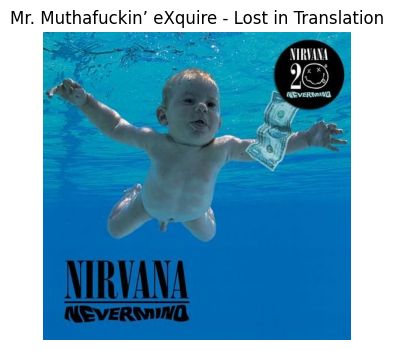


🔍 Top 5 albums visuellement similaires:

1. Nirvana - Nevermind [20th Anniversary Edition]
   Score: 1.000 | Genre: Rock

2. Nirvana - Nirvana
   Score: 0.829 | Genre: Rock

3. Nirvana - Incesticide
   Score: 0.807 | Genre: Rock

4. Nirvana - Live at the Paramount
   Score: 0.798 | Genre: Rock

5. Nirvana - In Utero (20th Anniversary Super Deluxe Edition)
   Score: 0.788 | Genre: Rock



In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Prendre Nevermind comme test
test_album_id = 13951
test_album = valid_metadata[test_album_id]

print(f"🎸 Album de test : {test_album['artist']} - {test_album['album_name']}")
print(f"   Genre: {test_album['genre']} | Année: {test_album['release_year']}\n")

# Charger et afficher l'image
test_image_path = f"/content/drive/MyDrive/shazam-visual/images/album_{test_album_id}.jpg"
test_image = Image.open(test_image_path)

plt.figure(figsize=(4,4))
plt.imshow(test_image)
plt.title(f"{test_album['artist']} - {test_album['album_name']}")
plt.axis('off')
plt.show()

# Générer l'embedding de cette image
inputs = processor(images=test_image, return_tensors="pt").to(device)
with torch.no_grad():
    query_embedding = model.get_image_features(**inputs).cpu().numpy()

faiss.normalize_L2(query_embedding)

# Rechercher les 5 albums les plus similaires
k = 5
distances, indices = index.search(query_embedding, k)

print(f"\n🔍 Top 5 albums visuellement similaires:\n")

for i, (idx, score) in enumerate(zip(indices[0], distances[0]), 1):
    album_info = valid_metadata[idx]
    print(f"{i}. {album_info['artist']} - {album_info['album_name']}")
    print(f"   Score: {score:.3f} | Genre: {album_info['genre']}")

    # Marquer si c'est l'album lui-même
    if idx == test_album_id:
        print(f"   ⭐ C'EST L'ALBUM DE DÉPART (match parfait!)")
    print()

In [ ]:
import torch

print("🧪 TEST : 'bébé qui nage dans une piscine'\n")

# Texte plus descriptif
query_text = "a baby swimming in a pool"

inputs = processor(text=[query_text], return_tensors="pt").to(device)

with torch.no_grad():
    text_embedding = model.get_text_features(**inputs).cpu().numpy()

faiss.normalize_L2(text_embedding)

# Top 10 résultats
k = 10
distances, indices = index.search(text_embedding, k)

print(f"🔍 Top 10 pour '{query_text}':\n")

for i, (idx, score) in enumerate(zip(indices[0], distances[0]), 1):
    album_info = valid_metadata[idx]

    # Highlight si c'est Nirvana
    highlight = "🎸 NIRVANA!" if 'nirvana' in album_info['artist'].lower() else ""

    print(f"{i}. {album_info['artist']} - {album_info['album_name']} {highlight}")
    print(f"   Score: {score:.3f} | Genre: {album_info['genre']}")
    print()

🧪 TEST : 'bébé qui nage dans une piscine'

🔍 Top 10 pour 'a baby swimming in a pool':

1. Diplo - Florida 
   Score: 0.296 | Genre: Electronic

2. Maxo - Debbie’s Son 
   Score: 0.289 | Genre: Rap

3. Shopping - The Official Body 
   Score: 0.288 | Genre: Rock

4. Sparks - Hippopotamus 
   Score: 0.280 | Genre: Electronic / Experimental / Rock

5. tobi lou - Live on Ice 
   Score: 0.279 | Genre: Rap

6. DJ Khaled - Grateful 
   Score: 0.278 | Genre: Rap

7. Lucrecia Dalt - ¡Ay! 
   Score: 0.278 | Genre: Experimental

8. Harry Styles - Harry Styles 
   Score: 0.276 | Genre: Pop/R&B

9. Lucy Liyou - Dog Dreams (개꿈) 
   Score: 0.270 | Genre: Electronic / Experimental

10. Kelela - Raven 
   Score: 0.269 | Genre: Pop/R&B



In [ ]:
# Test avec des éléments visuels clairs
test_queries = [
    "guitar",
    "microphone",
    "dark moody atmosphere",
    "colorful abstract art"
]

for query in test_queries:
    inputs = processor(text=[query], return_tensors="pt").to(device)
    with torch.no_grad():
        text_embedding = model.get_text_features(**inputs).cpu().numpy()

    faiss.normalize_L2(text_embedding)
    distances, indices = index.search(text_embedding, 3)

    print(f"🔍 '{query}':")
    for idx, score in zip(indices[0], distances[0]):
        album = valid_metadata[idx]
        print(f"   {album['artist']} - {album['album_name']} ({score:.3f})")
    print()

🔍 'guitar':
   Alan Sparhawk - Solo Guitar (0.286)
   Willie Nelson - It Always Will Be (0.285)
   @  - Mind Palace Music  (0.285)

🔍 'microphone':
   The Microphones - EARLY TAPES, 1996-1998 (0.308)
   FM3 - The Buddha Machine (0.278)
   Grateful Dead - May 1977: Get Shown the Light (0.274)

🔍 'dark moody atmosphere':
   Baths - Obsidian (0.282)
   Richard A. Ingram - Consolamentum (0.278)
   Slint - Spiderland (0.274)

🔍 'colorful abstract art':
   Carlos Niño & Friends - Flutes, Echoes, It's All Happening! (0.308)
   Underworld - Barking (0.305)
   The Minus 5 - In Rock (0.303)

